# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Flatten
from scipy.spatial.distance import cdist

%matplotlib inline

In [2]:
#@title
def plot_random_batch(batch, y_true, y_pred=None, batch_size=30, n_cols=10, figsize=(20, 10)):
    plt.figure(figsize=figsize)

    random_idx = np.random.choice(batch.shape[0], size=batch_size)
    x_batch = batch[random_idx].squeeze()
    y_batch = y_true[random_idx]

    y_pred = y_batch if y_pred is None else y_pred[random_idx]
    n_rows = x_batch.shape[0] // n_cols + 1
    is_gray = (batch.shape[-1] == 1) or (len(batch.shape) == 3)
    for img, true, pred, sub in zip(x_batch, y_batch, y_pred, range(1, len(batch)+1)):
        plt.subplot(n_rows, n_cols, sub)
        plt.imshow(img.astype(np.uint8), cmap='gray' if is_gray else None)

        plt.title("T:{} P:{}".format(true, pred), color = 'green' if true == pred else 'red')
        plt.axis('off')
    plt.tight_layout()

def plot_history(history, figsize=(12, 4), loss_train_key='loss', loss_val_key='val_loss', metric_train_key='accuracy', metric_val_key='val_accuracy'):
    loss_train = history.get(loss_train_key, [])
    loss_valid = history.get(loss_val_key, [])
    metric_train = history.get(metric_train_key, [])
    metric_valid = history.get(metric_val_key, [])

    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(loss_train, label='train')
    plt.plot(loss_valid, label='val')
    plt.ylim(0)
    plt.legend()

    if len(metric_train) > 0 or len(metric_valid) > 0:
        plt.subplot(1, 2, 2)
        plt.plot(metric_train, label='train')
        plt.plot(metric_valid, label='val')
        plt.ylim(top=1)
        plt.legend()

# Data Loading

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1) / 255
x_test = np.expand_dims(x_test, axis=-1) / 255

print(x_train.shape, x_train.dtype)
print(x_test.shape, x_test.dtype)

(60000, 28, 28, 1) float64
(10000, 28, 28, 1) float64


# Autoencoder

Metal device set to: Apple M1


2023-07-06 09:54:24.345361: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-06 09:54:24.345512: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_1 (Conv2D)              (None, 28, 28, 16)        160       
                                                                 
 pool_1 (MaxPooling2D)       (None, 14, 14, 16)        0         
                                                                 
 enc_2 (Conv2D)              (None, 14, 14, 8)         1160      
                                                                 
 encoded (MaxPooling2D)      (None, 7, 7, 8)           0         
                                                                 
 up_2 (UpSampling2D)         (None, 14, 14, 8)         0         
                                                                 
 dec_2 (Conv2D)              (None, 14, 14, 16)        1168      
                                                                 
 up_1 (UpSampling2D)         (None, 28, 28, 16)        0

2023-07-06 09:54:25.407533: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-06 09:54:25.770327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.1641

2023-07-06 09:54:40.678413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 16s 30ms/step - loss: 0.1641 - val_loss: 0.0872
Epoch 2/4
469/469 [==============================] - 14s 29ms/step - loss: 0.0846 - val_loss: 0.0813
Epoch 3/4
469/469 [==============================] - 13s 29ms/step - loss: 0.0808 - val_loss: 0.0787
Epoch 4/4
469/469 [==============================] - 14s 30ms/step - loss: 0.0787 - val_loss: 0.0770


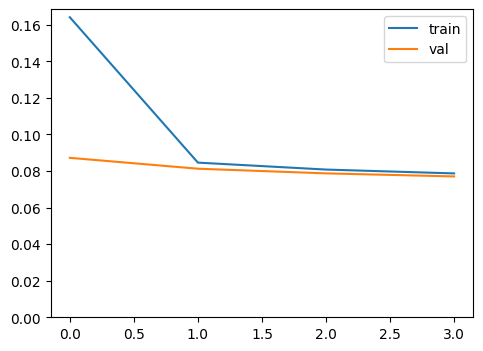

In [4]:
model = Sequential([
    # encoder
    Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name='enc_1', input_shape=(28, 28, 1)),
    MaxPool2D(pool_size=(2, 2), padding='valid', name="pool_1"),
    Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name='enc_2'),
    MaxPool2D(pool_size=(2, 2), padding='valid', name='encoded'),

    # decoder
    UpSampling2D(size=(2, 2), name="up_2"),
    Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name='dec_2'),
    UpSampling2D(size=(2, 2), name="up_1"),
    Conv2D(filters=1, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='sigmoid', name='decoded')
])
model.summary()

# binary cross entropy pra tentar acertar a classe do pixel
model.compile(optimizer='adam', loss='binary_crossentropy')

# batch=128 pra treinar mais rápido
hist = model.fit(x_train, x_train, batch_size=128, epochs=4, verbose=1, validation_data=(x_test, x_test))

plot_history(hist.history)

2023-07-06 09:55:23.582598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 424ms/step


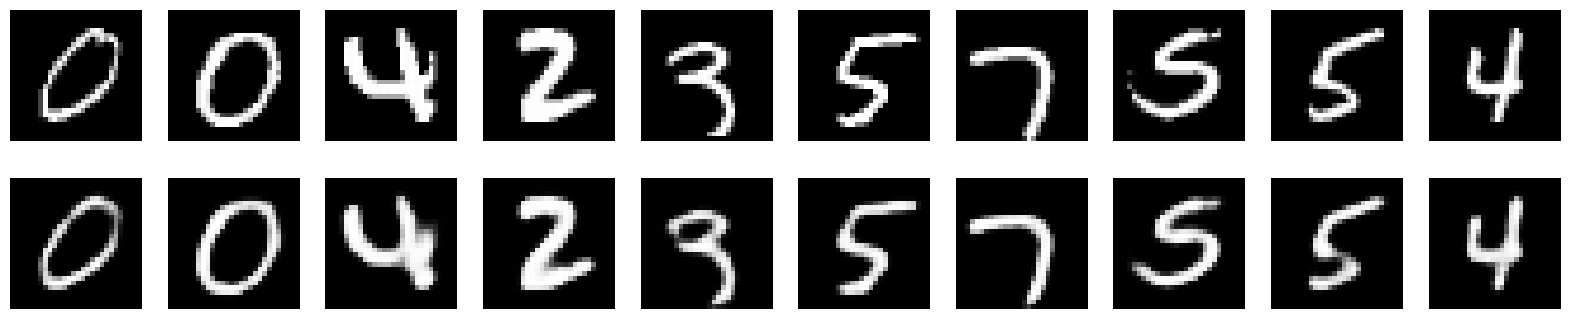

In [5]:
n_imgs = 10

random_idxs = np.random.choice(range(x_test.shape[0]), size=n_imgs)
im_ori = x_test[random_idxs]
im_dec = model.predict(im_ori)

plt.figure(figsize=(20, 4))
for i in range(n_imgs):
    plt.subplot(2, n_imgs, i + 1)
    plt.imshow(im_ori[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    plt.subplot(2, n_imgs, i + 1 + n_imgs)
    plt.imshow(im_dec[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

# Filtrando Ruído


In [6]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy,0.0, 1.0)
x_test_noisy  = np.clip(x_test_noisy, 0.0, 1.0)

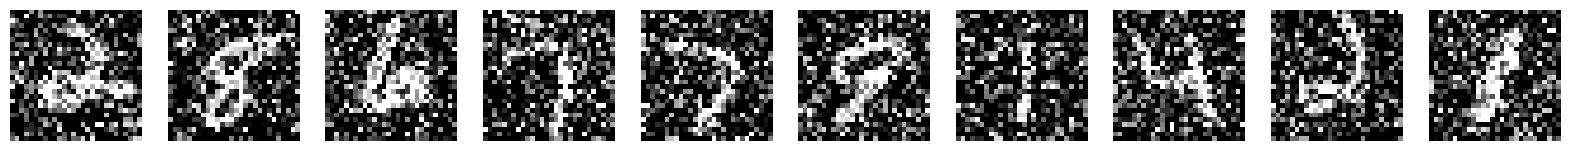

In [7]:
n_imgs = 10

random_idxs = np.random.choice(range(x_test_noisy.shape[0]), size=n_imgs)
im_ori = x_test_noisy[random_idxs]

plt.figure(figsize=(20, 4))
for i in range(n_imgs):
    plt.subplot(1, n_imgs, i + 1)
    plt.imshow(im_ori[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_1 (Conv2D)              (None, 28, 28, 16)        160       
                                                                 
 pool_1 (MaxPooling2D)       (None, 14, 14, 16)        0         
                                                                 
 enc_2 (Conv2D)              (None, 14, 14, 8)         1160      
                                                                 
 encoded (MaxPooling2D)      (None, 7, 7, 8)           0         
                                                                 
 up_2 (UpSampling2D)         (None, 14, 14, 8)         0         
                                                                 
 dec_2 (Conv2D)              (None, 14, 14, 16)        1168      
                                                                 
 up_1 (UpSampling2D)         (None, 28, 28, 16)       

2023-07-06 09:55:28.626484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.2191

2023-07-06 09:55:41.771925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 14s 30ms/step - loss: 0.2191 - val_loss: 0.1332
Epoch 2/4
469/469 [==============================] - 17s 35ms/step - loss: 0.1282 - val_loss: 0.1226
Epoch 3/4
469/469 [==============================] - 16s 34ms/step - loss: 0.1211 - val_loss: 0.1178
Epoch 4/4
469/469 [==============================] - 14s 30ms/step - loss: 0.1175 - val_loss: 0.1150


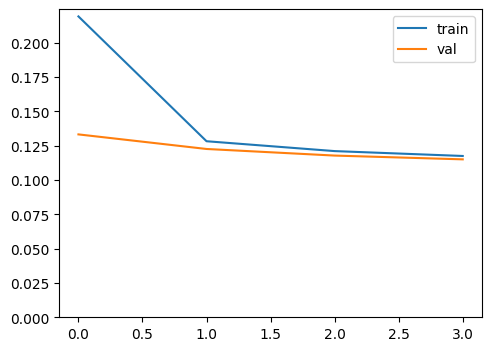

In [8]:
model_noisy = Sequential([
    # encoder
    Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name='enc_1', input_shape=(28, 28, 1)),
    MaxPool2D(pool_size=(2, 2), padding='valid', name="pool_1"),
    Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name='enc_2'),
    MaxPool2D(pool_size=(2, 2), padding='valid', name='encoded'),

    # decoder
    UpSampling2D(size=(2, 2), name="up_2"),
    Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name='dec_2'),
    UpSampling2D(size=(2, 2), name="up_1"),
    Conv2D(filters=1, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='sigmoid', name='decoded')
])
model_noisy.summary()

# binary cross entropy pra tentar acertar a classe do pixel
model_noisy.compile(optimizer='adam', loss='binary_crossentropy')

# batch=128 pra treinar mais rápido
hist = model_noisy.fit(
    x_train_noisy,
    x_train,
    batch_size=128,
    epochs=4,
    verbose=1,
    validation_data=(x_test_noisy, x_test)
)

plot_history(hist.history)

1/1 [==============================] - 0s 151ms/step


2023-07-06 09:56:29.609624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


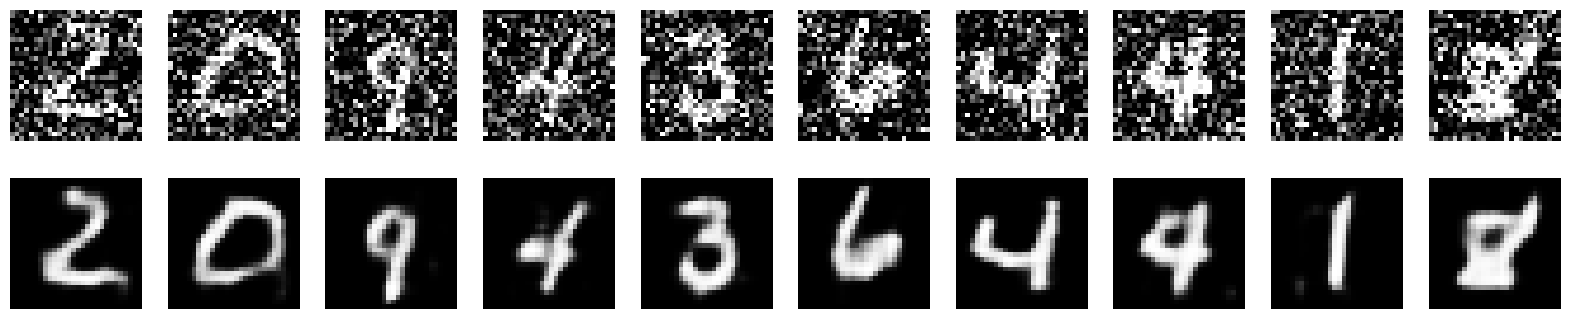

In [9]:
n_imgs = 10

random_idxs = np.random.choice(range(x_test_noisy.shape[0]), size=n_imgs)
im_ori = x_test_noisy[random_idxs]
im_dec = model_noisy.predict(im_ori)

plt.figure(figsize=(20, 4))
for i in range(n_imgs):
    plt.subplot(2, n_imgs, i + 1)
    plt.imshow(im_ori[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    plt.subplot(2, n_imgs, i + 1 + n_imgs)
    plt.imshow(im_dec[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

# Busca por Similaridade

In [10]:
encoder = Model(inputs=model.input, outputs=model.get_layer(name='encoded').output)
x_test_enc = encoder.predict(x_test)
x_test_enc.shape

122/313 [==========>...................] - ETA: 0s

2023-07-06 09:56:30.110600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 0s 1ms/step


(10000, 7, 7, 8)

In [11]:
embeddings = x_test_enc.reshape(x_test_enc.shape[0], -1)
embeddings.shape

(10000, 392)

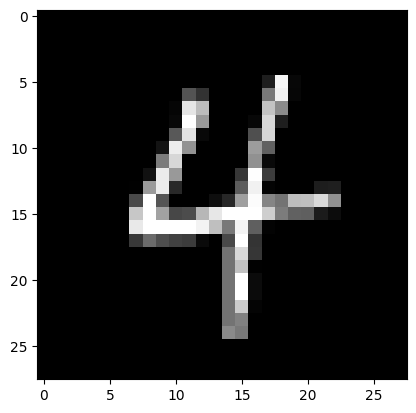

In [12]:
random_idx = np.random.choice(range(x_test.shape[0]), size=1)
im_ref = x_test[random_idx]
emb_ref = embeddings[random_idx]

plt.imshow(im_ref.squeeze(), cmap='gray')

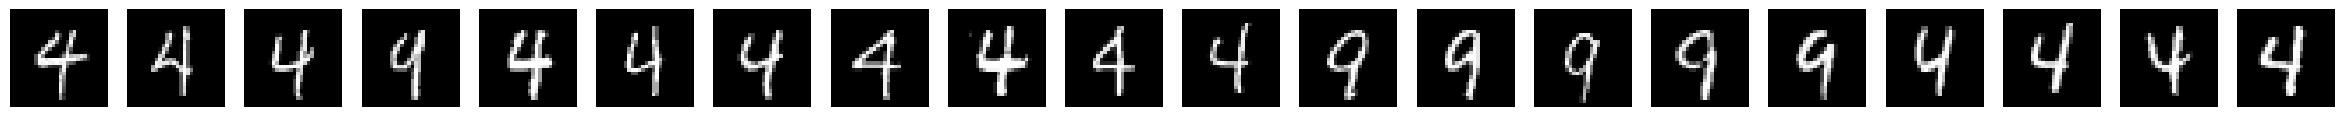

In [13]:
n_imgs = 20

distances = cdist(emb_ref, embeddings).squeeze()
closest_idxs = np.argsort(distances)[1:n_imgs+1] # from 1 because the img in 0 is the reference image itself

im_ori = x_test[closest_idxs]

plt.figure(figsize=(30, 4))
for i in range(n_imgs):
    plt.subplot(2, n_imgs, i + 1)
    plt.imshow(im_ori[i].reshape(28, 28), cmap='gray')
    plt.axis('off')